(3, 62, 242)
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


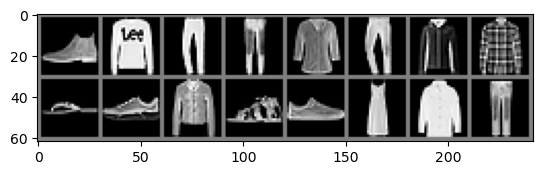

In [11]:
#this enviornment is TR
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import gc

# Fashion-MNIST : consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
augment_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),     
        transforms.ToTensor(), # 轉換為張量
        transforms.Normalize((0.5,), (0.5,)),
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=augment_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
test = (iter(test_loader))
print(test)
#print(len(test))
images, labels = next(test)

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(torchvision.utils.make_grid(images))
#torchvision.utils.make_grid() 的作用是将多张图像合并为一个网格，便于可视化多个图像。通常用于检查一批图像或查看生成模型（例如 GANs）输出的多张图像。
#print(len(test[]))
#print(type(iter(train_dataset)))
for image in images:
    print(image.shape)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [6]:
class Test_CNN(nn.Module):
    def __init__(self):
        super(Test_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        #self.fc3 = nn.Linear(64, 10)
        #self.dropout = nn.Dropout(p=0.3)

    def forward(self,x):
        x = self.conv1(x)
        #out = 16*28*28
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.pool(x)
        #out = 16*28*28
        x = self.relu(self.bn2(self.conv2(x)))
        #out = 32*28*28
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool_3(self.relu(self.bn4(self.conv4(x))))
        x = self.pool_3(self.relu(self.bn5(self.conv5(x))))
        #out = 256*7*7
        x = x.view(-1, 256 * 7 * 7)
        #x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        #x = self.fc3(x)

        return x
        

In [7]:

torch.cuda.empty_cache()
gc.collect() # 垃圾回收

3054

In [8]:
epochs = 20
lr = 0.001
model = Test_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 0.005)
#optimizer = optim.SGD(model.parameters(), lr=lr)  # 使用随机梯度下降优化器
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
for epoch in range(epochs):
  model.train()
  correct = 0
  total = 0
  running_loss = 0.0
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()


    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()# 反向傳播
    optimizer.step()# 更新參數

    running_loss += loss.item()

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    '''
    del images, labels, outputs
    torch.cuda.empty_cache()
    gc.collect() 
    '''
  # count the train loss and accurancy in order to draw a plt
  train_accuracy = 100 * correct / total
  train_loss = running_loss / len(train_loader)

  print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
  model.eval()
  correct = 0
  test_loss = 0.0 
  total = 0
  # testing set
  with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        '''
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()
        '''
  
  
  # count the test loss and accurancy in order to draw a plt
  test_accuracy = 100 * correct / total
  test_loss = test_loss / len(test_loader)
  print('Accuracy of the network on the validation images: {} % Validation Loss: {}'.format(test_accuracy, test_loss))
  scheduler.step()
  del images, labels, outputs
  torch.cuda.empty_cache()
  gc.collect()

print('\nFinished Training')

Epoch [1/20], Loss: 0.7370, Training Accuracy: 72.38%
Accuracy of the network on the validation images: 78.46 % Validation Loss: 0.5596494874715805
Epoch [2/20], Loss: 0.5553, Training Accuracy: 79.59%
Accuracy of the network on the validation images: 82.52 % Validation Loss: 0.4854013792037964
Epoch [3/20], Loss: 0.5031, Training Accuracy: 81.60%
Accuracy of the network on the validation images: 80.46 % Validation Loss: 0.5284073350071907
Epoch [4/20], Loss: 0.4839, Training Accuracy: 82.28%
Accuracy of the network on the validation images: 83.71 % Validation Loss: 0.4618487347483635
Epoch [5/20], Loss: 0.4698, Training Accuracy: 82.89%
Accuracy of the network on the validation images: 84.31 % Validation Loss: 0.4514383850038052
Epoch [6/20], Loss: 0.3995, Training Accuracy: 85.53%
Accuracy of the network on the validation images: 86.36 % Validation Loss: 0.38577755680680276
Epoch [7/20], Loss: 0.3863, Training Accuracy: 86.23%
Accuracy of the network on the validation images: 87.13 %